# Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [515]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn

import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.colors import ListedColormap

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")


# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# From GDTW example code
import torch
from AligningTimeSeries.Code.GDTW import gromov_dtw 
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from imageio import imread
import sklearn

In [516]:
# Y-position of hand and end-effector tend to be most consistently aligned. Use those to discover the time warp mapping

# Import data from csvs
end_eff_raw = pd.read_csv(r'C:\Users\jmoln\Documents\Projects\NonAnthroHands_User_Study\data\positions\positions_0_data\j2s6s300_end_effectorMotion_1.csv')
end_eff_data = end_eff_raw.to_numpy()
end_eff_pos = (end_eff_data[...,0],end_eff_data[...,2])
#print (end_eff_posX)

hand_raw = pd.read_csv(r'C:\Users\jmoln\Documents\Projects\NonAnthroHands_User_Study\data\positions\positions_0_data\RightHandAnchorMotion_1.csv')
hand_data = hand_raw.to_numpy()
hand_pos = (hand_data[...,0],hand_data[...,2])

x = end_eff_pos
y = hand_pos

Text(0.5, 1.0, 'Normalized DTW Distance')

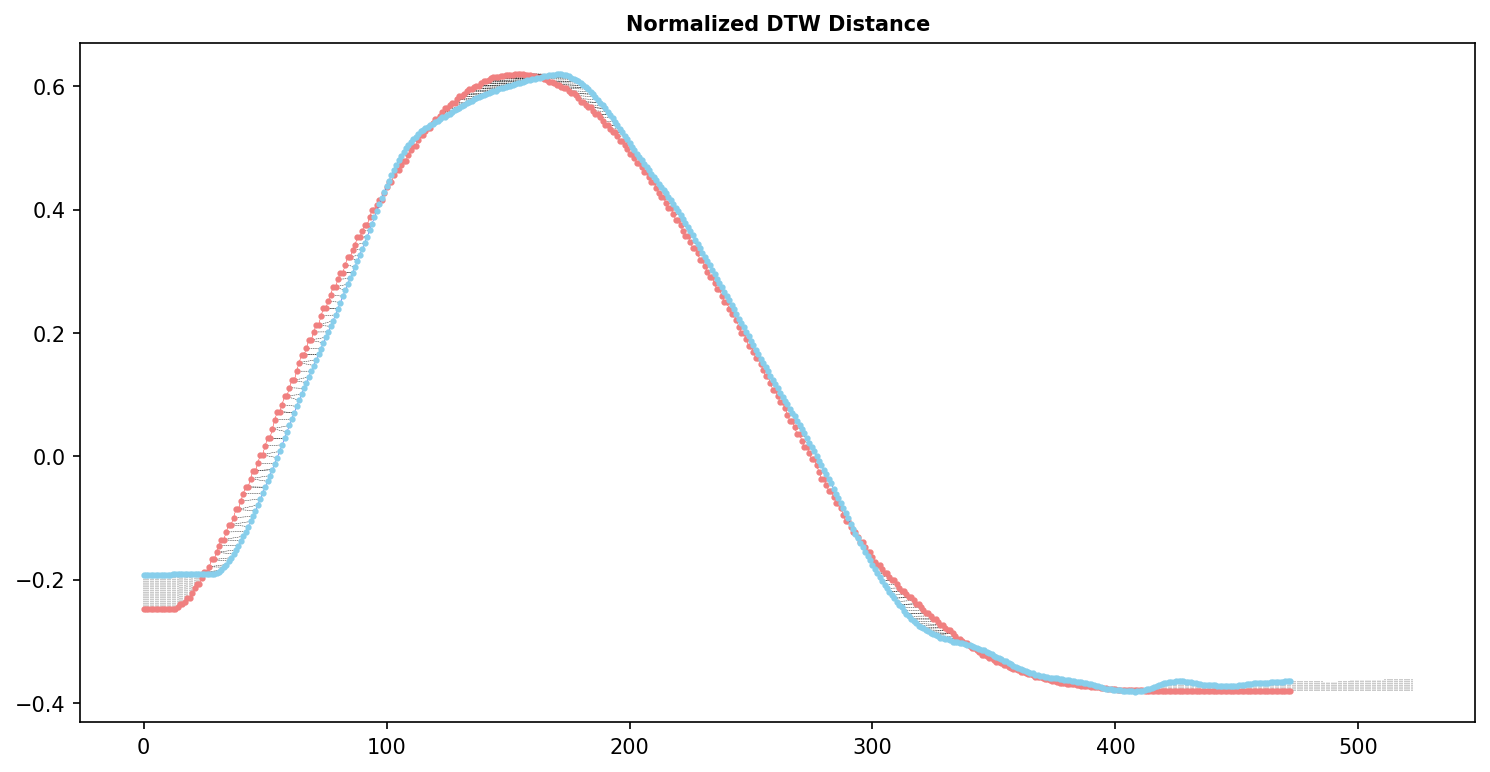

In [517]:
# Normalize x and y to prevent scaling issues from creating DTW misalignment

scale_x = 1/(np.max(x[1])-np.min(x[1]))
scale_y = 1/(np.max(y[1])-np.min(y[1]))

center_x = np.mean(x[1])
center_y = np.mean(y[1])

x_norm = (x[0],(x[1] - center_x)*scale_x)
y_norm = (y[0],(y[1] - center_y)*scale_y)

# TO-DO: trim ends for cleaner DTW
# (Not done yet)

dtw_distance, warp_path = fastdtw(x_norm[1], y_norm[1], dist=euclidean) 

# Show normalized plots
fig, ax = plt.subplots(figsize=(12, 6))

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('on')

max_distance = 0;
i = 0;

for [map_x, map_y] in warp_path:
    
    ax.plot([map_x, map_y], [x_norm[1][map_x], y_norm[1][map_y]], '--k', linewidth=0.2)
    temp_arr2 = np.array((x_norm[1][map_x], y_norm[1][map_y]))
    max_distance = np.maximum(max_distance, np.linalg.norm(temp_arr2))
    i=i+1


ax.plot(x_norm[1][:-50], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y_norm[1][:-50], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("Normalized DTW Distance", fontsize=10, fontweight="bold")

In [518]:
# Take the warp_path generated from normalized hand/URDF data and use that to align all other hand data

# Time marks: 
time_URDF = end_eff_data[...,0]
time_hand = hand_data[...,0]

# remember that x = end_eff_pos
#               y = hand_pos

# Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

wp_size = len(warp_path)
time_URDF_aligned = np.zeros(wp_size)
time_hand_aligned = np.zeros(wp_size)
end_eff_pos_aligned = np.zeros((wp_size,3))
end_eff_rot_aligned = np.zeros((wp_size,3))
hand_pos_aligned = np.zeros((wp_size,3))
hand_rot_aligned = np.zeros((wp_size,3))

for i, [map_x, map_y] in enumerate(warp_path, start=0):   
    time_URDF_aligned[i] = time_URDF[map_x]
    time_hand_aligned[i] = time_hand[map_y]
    end_eff_pos_aligned[i][0:3] = end_eff_data[map_x][1:4]
    end_eff_rot_aligned[i][0:3] = end_eff_data[map_x][4:]
    hand_pos_aligned[i][0:3]    = hand_data[map_y][1:4]
    hand_rot_aligned[i][0:3]    = hand_data[map_y][4:]

Text(0.5, 0.92, 'DTW Alignment of Hand and URDF End-Effector Position')

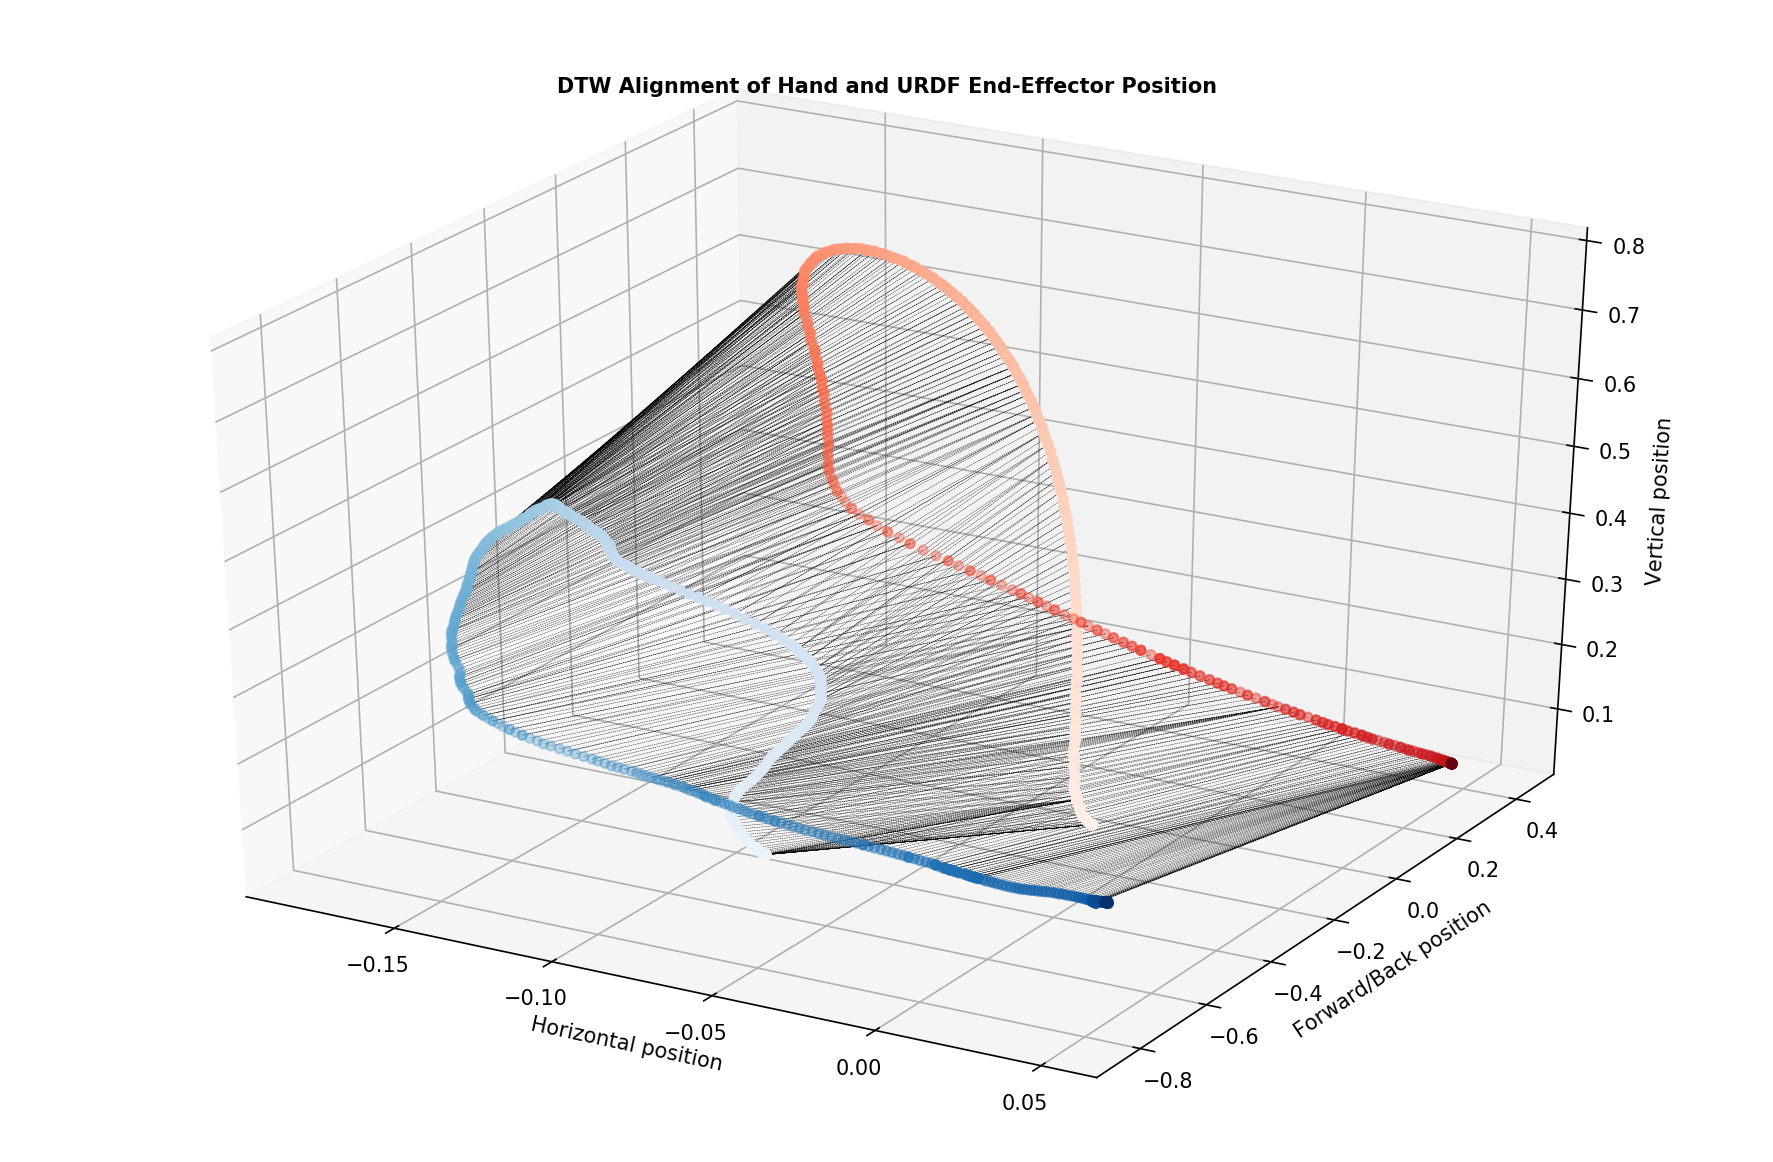

In [493]:
fig, ax = plt.subplots(figsize=(15, 10))

# Show the border and axes ticks,
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

# ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[0], '-ro', label='End-effector position', \
#     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
# ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[1], '-ro', label='End-effector position', \
#     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
# ax.plot(time_URDF_aligned, end_eff_pos_aligned[:].T[2], '-ro', label='End-effector position', \
#     linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')

# Unity uses a left-handed coordinate system, so plot your position data in the orientation in which it was gathered:
#  X moving left to right, Z moving front to back, and Y pointing up and down
ax.scatter(end_eff_pos_aligned[:].T[0], -end_eff_pos_aligned[:].T[2], end_eff_pos_aligned[:].T[1], \
            c=time_URDF_aligned/max(time_URDF), cmap='Reds', label='End-effector position')
ax.scatter(hand_pos_aligned[:].T[0]   , -hand_pos_aligned[:].T[2]   , hand_pos_aligned[:].T[1]   , \
           c=time_hand_aligned/max(time_hand), cmap='Blues', label='Hand position')

# ax.plot3D(end_eff_pos_aligned[:].T[0], end_eff_pos_aligned[:].T[1], end_eff_pos_aligned[:].T[2], \
#     '-ro', label='End-effector position', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
# ax.plot3D(hand_pos_aligned[:].T[0]   , hand_pos_aligned[:].T[1]   , hand_pos_aligned[:].T[2]   , \
#     '-bo', label='Hand position', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

for [map_x, map_y] in warp_path: 
    ax.plot3D([end_eff_pos_aligned[map_x].T[0], hand_pos_aligned[map_y].T[0]], \
              [-end_eff_pos_aligned[map_x].T[2], -hand_pos_aligned[map_y].T[2]],\
              [end_eff_pos_aligned[map_x].T[1], hand_pos_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)

ax.set_xlabel('Horizontal position')
ax.set_ylabel('Forward/Back position')
ax.set_zlabel('Vertical position')

ax.set_title("DTW Alignment of Hand and URDF End-Effector Position", fontsize=10, fontweight="bold")

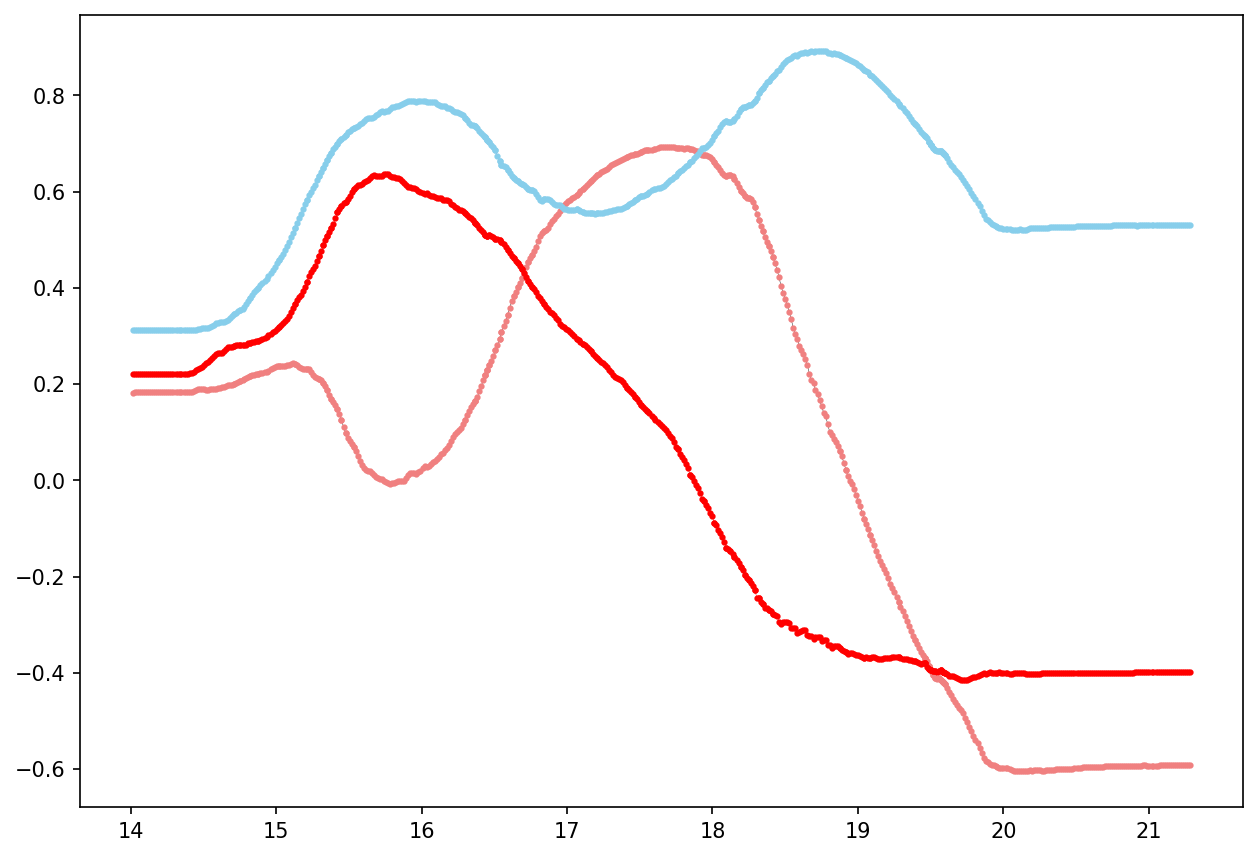

In [524]:
# Fix angle inversion issues for hand data

fig, ax = plt.subplots(figsize=(10, 7))

for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=1):
    # Singularities should occur in all axes simultaneously
    if i==len(hand_rot_aligned):
        continue
    elif np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-1].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-1].T[0]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
        hand_rot_aligned[i] = -hand_rot_aligned[i]
    elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-1].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-1].T[1]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
        hand_rot_aligned[i] = -hand_rot_aligned[i]
    elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-1].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-1].T[2]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
        hand_rot_aligned[i] = -hand_rot_aligned[i]
        
        
# for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=2):
#     # Singularities should occur in all axes simultaneously
#     if np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-2].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-2].T[0]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
#         hand_rot_aligned[i] = -hand_rot_aligned[i]
#     elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-2].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-2].T[1]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
#         hand_rot_aligned[i] = -hand_rot_aligned[i]
#     elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-2].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-2].T[2]):
#         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
#         hand_rot_aligned[i] = -hand_rot_aligned[i]
    
ax.plot(time_hand_aligned, hand_rot_aligned[:].T[0], '-ko', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(time_hand_aligned, hand_rot_aligned[:].T[1], '-bo', label='x', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.plot(time_hand_aligned, hand_rot_aligned[:].T[2], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='red', markeredgecolor='red')



Text(0.5, 0.92, 'DTW Alignment of Hand and URDF End-Effector Orientation')

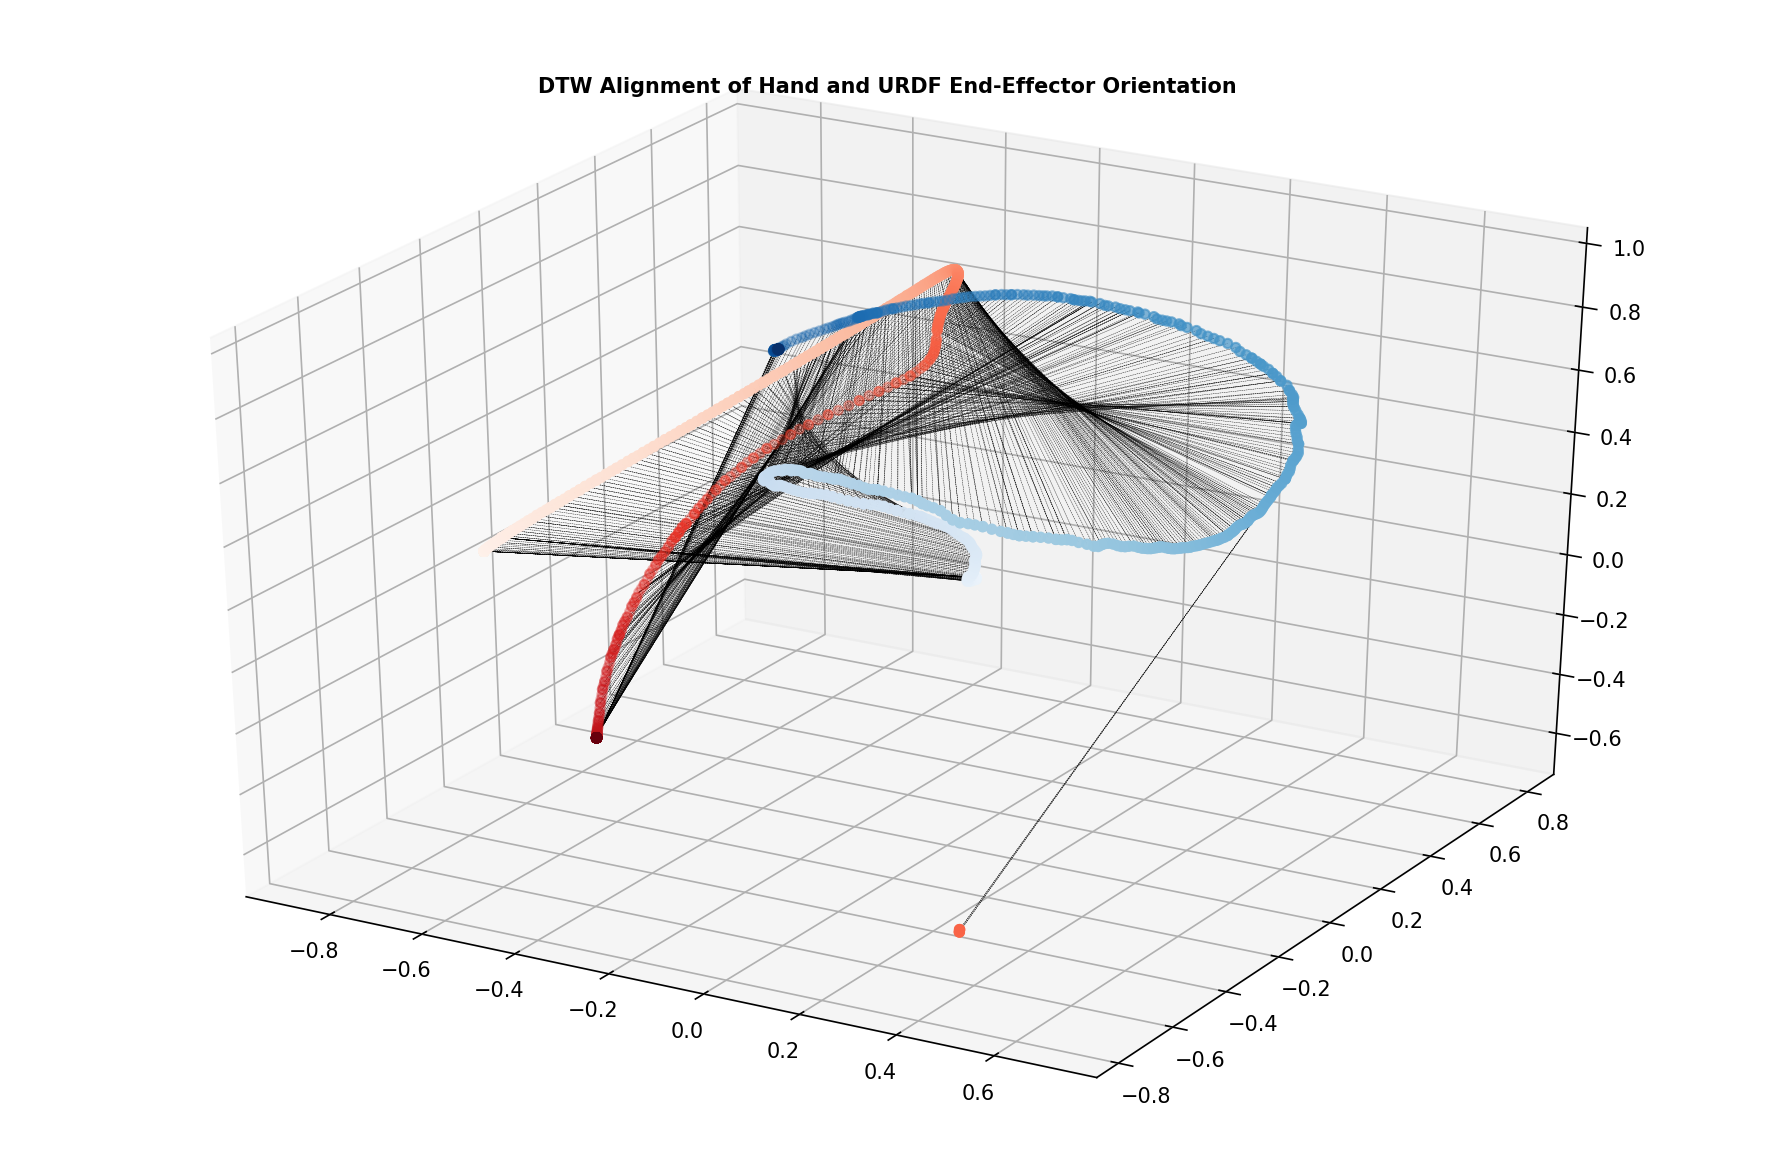

In [530]:
# Plot DTW-aligned hand/end-effector orientation

fig, ax = plt.subplots(figsize=(15, 10))

# Show the border and axes ticks
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

ax.scatter(end_eff_rot_aligned[:].T[0], -end_eff_rot_aligned[:].T[2], end_eff_rot_aligned[:].T[1], \
          c=time_URDF_aligned/max(time_URDF), cmap='Reds', label='End-effector orientation')
ax.scatter(hand_rot_aligned[:].T[0]   , -hand_rot_aligned[:].T[2]   , hand_rot_aligned[:].T[1]   , \
          c=time_hand_aligned/max(time_hand), cmap='Blues', label='Hand orientation')

for [map_x, map_y] in warp_path: 
    ax.plot3D([end_eff_rot_aligned[map_x].T[0], hand_rot_aligned[map_y].T[0]], \
              [-end_eff_rot_aligned[map_x].T[2], -hand_rot_aligned[map_y].T[2]],\
              [end_eff_rot_aligned[map_x].T[1], hand_rot_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)
    
ax.set_title("DTW Alignment of Hand and URDF End-Effector Orientation", fontsize=10, fontweight="bold")

Text(0.5, 0.92, 'DTW Alignment of Hand and URDF End-Effector Position')

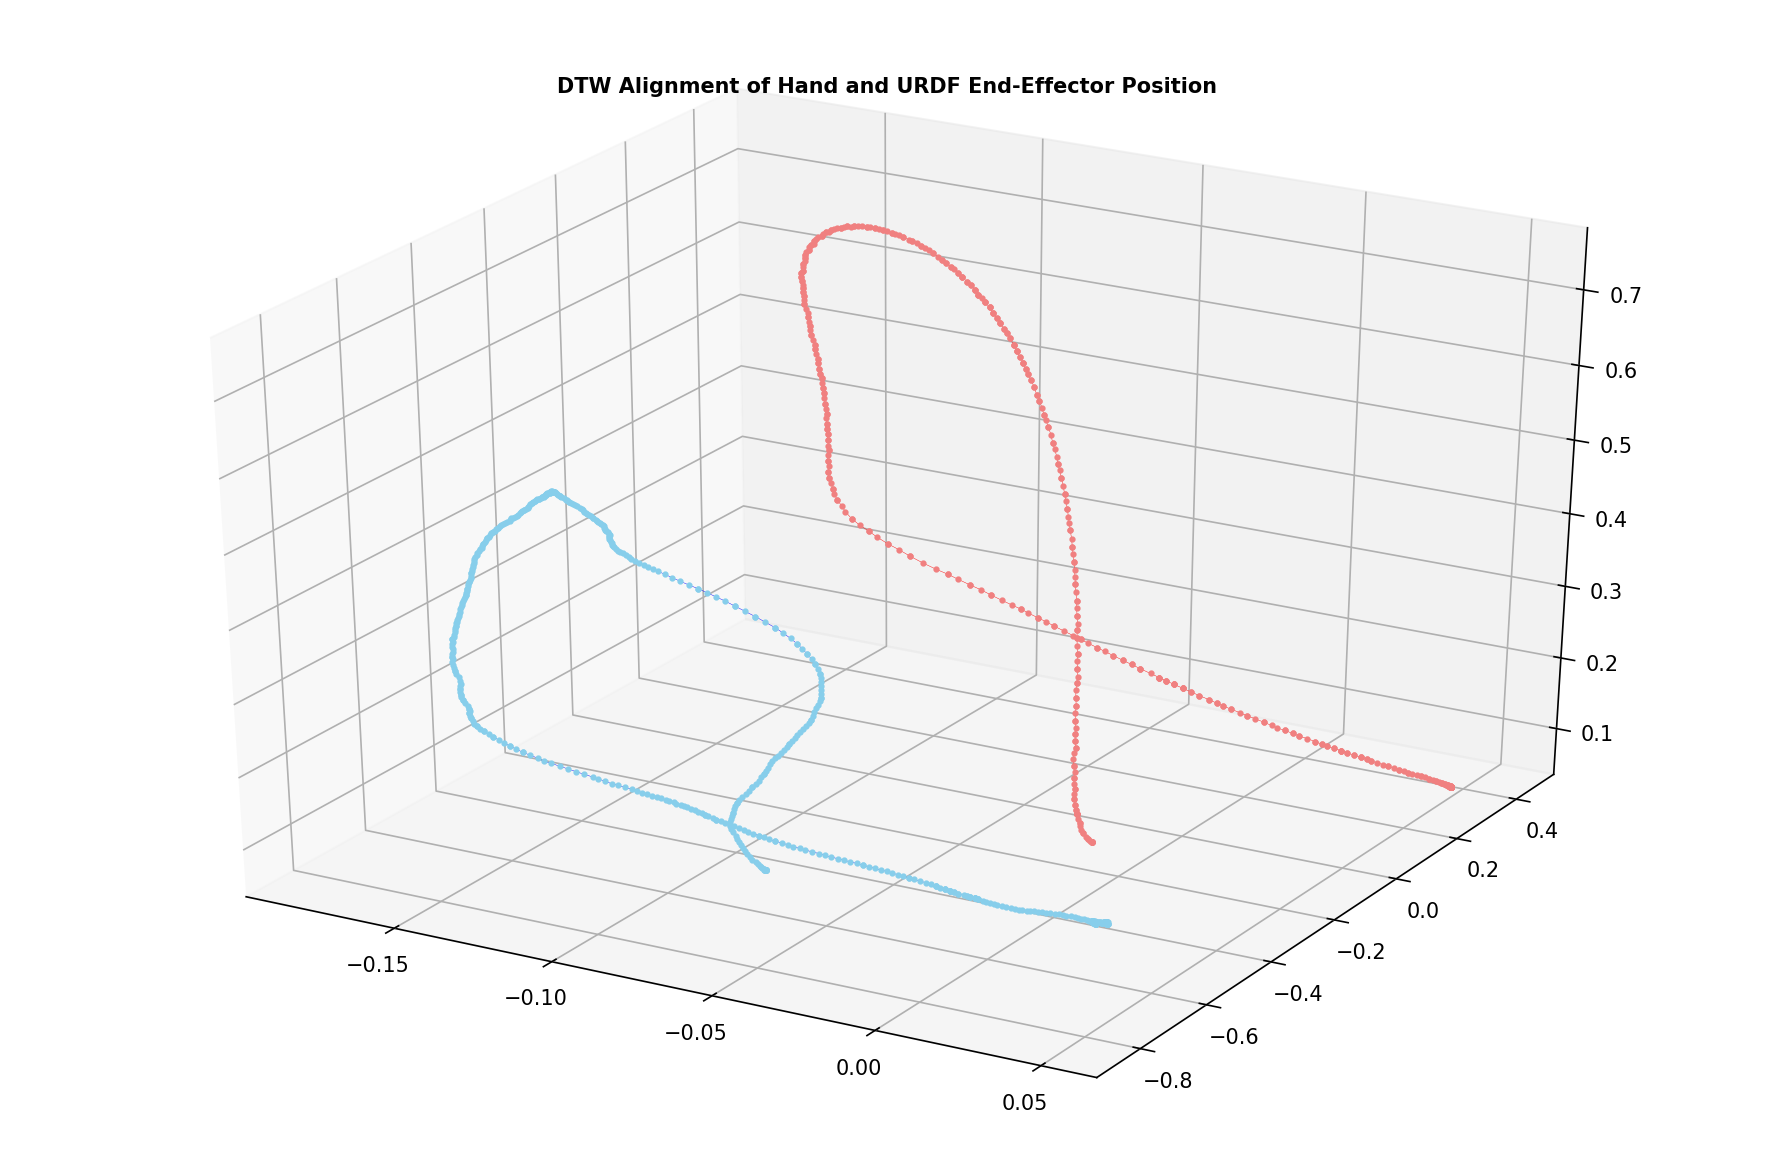

In [528]:
fig, ax = plt.subplots(figsize=(15, 10))

# Show the border and axes ticks
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

ax.plot3D(end_eff_pos_aligned[:].T[0], -end_eff_pos_aligned[:].T[2], end_eff_pos_aligned[:].T[1],\
          '-ro', label='End-effector position', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot3D(hand_pos_aligned[:].T[0]   , -hand_pos_aligned[:].T[2]   , hand_pos_aligned[:].T[1]   ,\
          '-bo', label='Hand position', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Alignment of Hand and URDF End-Effector Position", fontsize=10, fontweight="bold")

In [507]:
hand_rot_aligned[75]=-hand_rot_aligned[75]

In [508]:
hand_rot_aligned[75]

array([0.2375452, 0.4508628, 0.3148484])

In [497]:
np.abs(-0.5717824 - 0.5760468)

1.1478291999999999

In [498]:
np.abs(-0.5717824 +  0.5760468)

0.004264399999999946

In [499]:
Out[497]>Out[498]

True